# Introducción a Python

## La librería astropy

La librería ***astropy*** contiene varias herramientas que nos permiten realizar cálculos tomando en cuenta las unidades de nuestras variables. Nos permite trabajar y convertir las coordenadas de objetos celestes. Manejar imagenes en formato fits y acceder a catalogos de objetos astronómicos. 

## Manejo de Unidades

Las unidades y constantes físicas están organizadas en los sub-modulos **constants** e **units**. Ambos sub-modules utilizan la clase **Quantity** para llevar el control y realizar las operaciones tanto de los valores como del análisis dimensional

In [ ]:
from astropy import units as uts
from astropy import constants as cts

distancia = 100*uts.km
tiempo = 1.5*uts.hr

velocidad = distancia/tiempo

print ("Tu velocidad es {}".format (velocidad))

Los objetos de la clase **Quantity** tienen dos elementos principales:

 1. value que contiene el valor escalar
 1. unit que contiente las unidades
 
 además tiene el soporte para realizar conversiones de unidades usando el método **to**

In [ ]:
print ("El valor de la velocidad es {} con unidades {}".format(velocidad.value, velocidad.unit))
print ("La velocidad es {}".format (velocidad.to("m/s")))
print ("La velocidad es {}".format (velocidad.to("AU/yr")))

Podemos calcular el factor de Lorentz con la velocidad de la luz:

In [ ]:
beta = velocidad / cts.c
print (beta)

Podemos ver que las unidades no se simplifican automáticamente. Para forzar la simplificación usamos la función **decompose**:

In [ ]:
beta = beta.decompose()
print (beta)

Otra opción es solicitar un valor adimensional con la función **to**

In [ ]:
beta = velocidad / cts.c
print (beta.to(""))

### Ejemplo práctico: Radiación de cuerpo negro

La densidad espectral de energía emitida por un cuerpo  negro esta dado por la ley de Planck:

$$B(\nu,T) = \frac{2h\nu^3}{c^2} \frac{1}{\left(e^{\frac{h\nu}{kT}}-1\right)},$$

donde $\nu$ es la frecuencia en Hz, $T$ es la temperatura del cuerpo negro, $h$ es la constante de Planck, $c$ es la velocidad de la luz y $k$ es la constante de Boltzman. Definamos una función que nos permita evaluar esta función para cualquier combinación de frecuencia y temperatura.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as uts
from astropy import constants as cts

def black_body(nu, T):
    c = cts.c      #Velocidad de la luz 
    h = cts.h      #Constante de Planck
    k = cts.k_B    #Constante de Boltzman
    
    C1 = 2*h/c**2
    x = h*nu/(k*T)
    bbody = C1*nu**3 * (np.exp(x)-1)**-1/uts.sr
    return bbody.to("J/(s m2 Hz sr)")

Ahora gráfiquemos para diferentes valores de temperatura:

/home/domars/.local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/domars/.local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, 'Densidad de Energía (J / (Hz m2 s))')

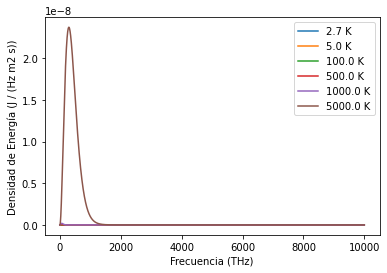

In [2]:
nu = np.geomspace (1e-1,1e4, 10000, dtype=np.float128)* uts.THz
T = np.array ([2.7,5,100, 500, 1000, 5000], dtype=np.float128)* uts.K

plt.figure()

for iTemp in T:
    ibbody = black_body(nu,iTemp)
    plt.plot (nu, ibbody, label = "{}".format(iTemp))

plt.legend()
plt.xlabel("Frecuencia ({})".format(nu.unit))
plt.ylabel("Densidad de Energía ({})".format(ibbody.unit))


En casos donde tenemos varios ordenes de mágnitud de diferencia, conviene generar nuestras gráficas en escala logarítmica:

/home/domars/.local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/domars/.local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(1e-20, 1e-07)

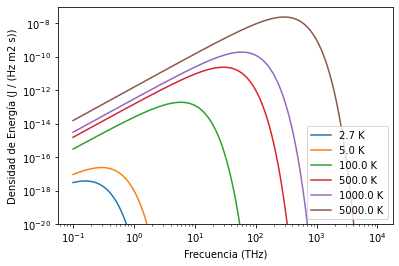

In [3]:
for iTemp in T:
    ibbody = black_body(nu,iTemp)
    plt.plot (nu, ibbody, label = "{}".format(iTemp))

plt.legend(loc="best")
plt.xlabel("Frecuencia ({})".format(nu.unit))
plt.ylabel("Densidad de Energía ({})".format(ibbody.unit))
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-20,1e-7)

Ahora calculemos la densidad de energía bolométrica del sol, es decir, integramos en frecuencia: $$ \int_0^\infty B(\lambda,T) \mathrm{d} \nu.$$ Para ello utilizaremos la regla del trapecio para integrar: $$\int_a^b f(x) dx \simeq \frac{b-a}{n} \left(\frac{f(a)+f(b)}{2} + \sum_{i=1}^n f\left(a+i*\frac{b-a}{n}\right)\right),$$ donde $n$ es el número de intervalos que se emplean para aproximar la integral.

In [4]:
def integral_bb (a, b, T, num_pts=1000.):
    
    delta = (b-a)/num_pts

    suma = (black_body(a,T)+black_body(b,T))/2.0
    for i in np.arange(1,num_pts):
        suma += black_body (a + i*delta,T)
    return suma*delta

temp_sol = 5778*uts.K
sol_model = integral_bb (1*uts.THz, 1e4*uts.THz, temp_sol)
sol_model = sol_model.to ("W m-2")
print (sol_model)


20117376.942389265 W / m2


La ley de Stefan-Boltzmann nos dice que la densidad de energía bolométrica es proporcional a la cuarta potencia de la potencia, esto es: $$ \int_0^\infty B(\lambda,T) \mathrm{d} \nu = \sigma_{B} T^4,$$ donde $\sigma_{B}=5.67037442\times10^{8}\, \mathrm{J / s K^4 m^2}$ es la constante de Stefan-Boltzmann. Comparemos con el resultado de nuestra integral:

In [6]:
stef_boltz = cts.sigma_sb*temp_sol**4
print (stef_boltz.to("W m-2"))
print (stef_boltz/sol_model)

63200699.73684546 W / m2
3.1415974318041164


¿Por qué no obtenemos el mismo resultado?

## Ángulos y coordenadas celestes

Astropy incluye la representación de las coordenadas celestes y las transformaciones entre ellas. La base de esta funcionalidad son los objetos tipos **Angle**.

In [8]:
from astropy.coordinates import Angle

ra = Angle ("13:47:30", unit = uts.h)
dec = Angle ("-11:45:00", unit = uts.degree)

Ahora usamos alguno de los marcos de referencia disponibles en la librería:

In [9]:
from astropy.coordinates import ICRS, FK5, FK4

posicion = ICRS(ra,dec)
posicion2 = FK5 (ra,dec)
posicion3 = FK4 (ra,dec)

print(posicion.separation(posicion2))
print(posicion.separation(posicion3))


0d00m00.02688699s
0d41m54.7038421s


Podemos transformar a coordenadas galácticas:

In [10]:
from astropy.coordinates import Galactic

pos_gal = posicion.transform_to(Galactic)
print ("El objeto en coordenadas galácticas: {},{}".format(pos_gal.l, pos_gal.b))


El objeto en coordenadas galácticas: 324.0352807224032 deg,48.81104072948765 deg


Para la conversión a coordenas alt-acimutales, necesitamos definir una posición geográfica y la hora UT:

Text(0, 0.5, 'Acimut (grados)')

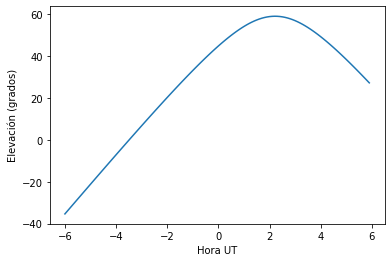

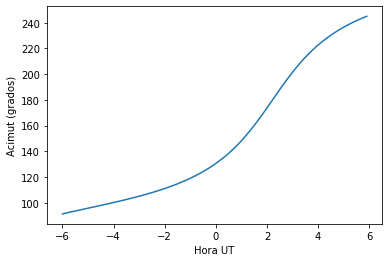

In [11]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

LMT_Site = EarthLocation(lat=Angle('18d59m06s', unit=uts.degree),\
                         lon=Angle('-97d18m53s', unit=uts.degree),\
                         height=4560*uts.m)

hoy = Time ("2022-06-23 00:00")

horas =  np.arange(-6,6,0.1)*uts.h
marco_azel = AltAz(obstime=hoy+horas,
                   location=LMT_Site)

pos_azel = posicion.transform_to(marco_azel)


plt.plot(horas,pos_azel.alt.value)
plt.xlabel("Hora UT")
plt.ylabel("Elevación (grados)")
plt.figure()
plt.plot(horas,pos_azel.az.value)
plt.xlabel("Hora UT")
plt.ylabel("Acimut (grados)")


Para objetos del sistema solar, podemos cargar las efemérides con la función **get_body**

Text(0, 0.5, 'Acimut (grados)')

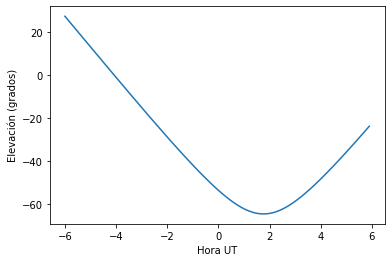

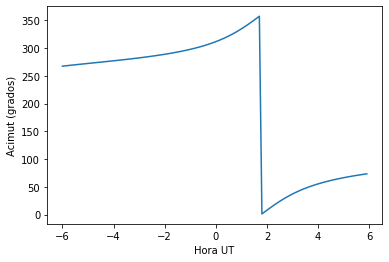

In [12]:
from astropy.coordinates import get_body

mars_coords = get_body("mars", hoy+horas, LMT_Site)

marte_azel = mars_coords.transform_to(marco_azel)
plt.plot(horas, marte_azel.alt)
plt.xlabel("Hora UT")
plt.ylabel("Elevación (grados)")
plt.figure()
plt.plot(horas, marte_azel.az)
plt.xlabel("Hora UT")
plt.ylabel("Acimut (grados)")

Con la siguiente instrucción podemos obtener una lista de los objetos que podemos usar con la función get_body

In [13]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.bodies


('earth',
 'sun',
 'moon',
 'mercury',
 'venus',
 'earth-moon-barycenter',
 'mars',
 'jupiter',
 'saturn',
 'uranus',
 'neptune')


## Manejo de imágenes en formato FITS


El formato fits es bastante popular en la comunidad astronómica para la difusión de datos y observaciones. 

Para abrir un archivo fits tenemos que utilizar las rutinas de astropy

In [14]:
from astropy.io import fits
from matplotlib import pyplot

im = fits.open ("hst_12309_01_wfc3_uvis_f656n_drz.fits")


Los fits estan organizados en HDU (Header Data Unit). Un fits puede contener varios HDU. La función open regresa la lista de los hdu disponobles en el archivo

In [15]:
print ("Numero de HDUs: ", len(im))

Numero de HDUs:  6


La información de la imagen esta guardada en el atributo **data**. Primero verificamos las dimensiones de los datos de cada HDU:

In [16]:
for i,ihdu in enumerate(im):
    try:
        print ("El HDU {} tiene una dimension de {}".format(i,ihdu.data.shape))
    except:
        print ("El HDU {} no contiene un arreglo con datos".format(i))

El HDU 0 no contiene un arreglo con datos
El HDU 1 tiene una dimension de (5800, 5656)
El HDU 2 tiene una dimension de (5800, 5656)
El HDU 3 tiene una dimension de (5800, 5656)
El HDU 4 tiene una dimension de (4,)
El HDU 5 tiene una dimension de (5800, 5656)


Vemos que el archivo contiene varias imágenes. Intentemos con la primera

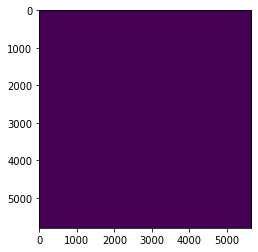

In [27]:
data = im[1].data

plt.imshow (data)

No se puede apreciar mucho detalle, por lo que procedemos a ajustar la escala de la misma. Una buena aproximación es calcular la media y la desviación estándar de la imagen:

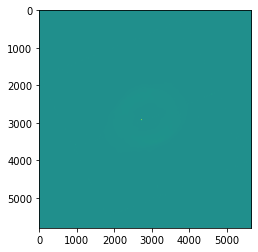

In [18]:
media = data.mean()
devstd = data.std()

numstd = 3

plt.imshow(data, vmin = media-numstd*devstd, vmax=media + numstd*devstd)

Muchas veces los valores del promedio y la desviación estándar pueden verse afectados (sesgados) por valores extremos (outliers):

In [19]:
print (media, devstd)
print (data.min(), data.max())

0.034581296 9.853648
-0.028128875 53946.867


Podemos mitigar esto con la función **sigma_clipped_stats**

In [20]:
from astropy.stats import sigma_clipped_stats
cmedia, cmediana, cdevstd =  sigma_clipped_stats(data,sigma = 5.)

print (cmedia, cdevstd)

0.009204701 0.036449958


Y ahora ajustamos la escala que se usa para desplegar la imagen

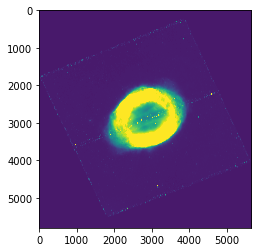

In [24]:
numstd = 10

plt.imshow(data, vmin = cmedia-cdevstd, vmax=cmedia + numstd*cdevstd)

Podemos emplear las funciones de la librería WCS (World Coordinate System) para producir una gráfica con la orientación y los valores de coordenadas correctos:

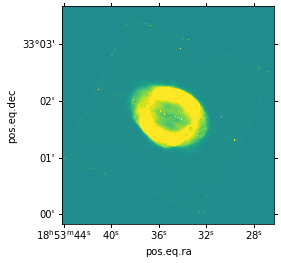

In [28]:
from astropy.wcs import WCS

wcs = WCS(im[1].header)
fig = plt.figure()
fig.add_subplot(111, projection = wcs)
plt.imshow(data, vmin = cmedia-numstd*cdevstd, vmax=cmedia + numstd*cdevstd)

In [29]:
im[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5656                                                  
NAXIS2  =                 5800                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ibh601a1q                         ' / rootname of the observation set
EXPNAME = 'ibh601a1q                ' / exposure identifier                     
BUNIT   = 'ELECTRONS/S'     

Como podemos apreciar, la información de las coordenadas se almacena en el encabezado. Por ejemplo, la posición (x,y) del pixel de referencia y sus correspondientes en coordenadas ecuatoriales se obtiene así

In [31]:
print ("Pixel de referencia: ", \
       im[1].header["CRPIX1"], im[1].header["CRPIX2"])
print ("Coordenadas Equatoriales en grados", \
        im[1].header["CRVAL1"],im[1].header["CRVAL2"])
print ("Tamaño de pixel en grados", \
        im[1].header["CD1_1"]*3600,im[1].header["CD2_2"])

Pixel de referencia:  2828.0 2900.0
Coordenadas Equatoriales en grados 283.3967283281104 33.02918214895566
Tamaño de pixel en grados -0.0396200008690344 1.10055557969543e-05


In [32]:
angle_ra = Angle (im[1].header["CRVAL1"], 'degree')
angle_dec = Angle (im[1].header["CRVAL2"], 'degree')

print (angle_ra.hms)
print (angle_dec.dms)


hms_tuple(h=18.0, m=53.0, s=35.21479874650851)
dms_tuple(d=33.0, m=1.0, s=45.055736240385045)


## El toolbox para cálculos cosmológicos

**Astropy** contiene varias clases que se pueden emplear para calcular la edad del universo o la distancia de luminosidad para diferentes cosmologías:

In [33]:
from astropy.cosmology import WMAP9, Planck15

print ("WMAP 9")
print ("Valor actual de la constante de Huble {}".format(WMAP9.H0))
print ("Valor de la edad del universo {}".format(WMAP9.age(0)))
print ("Planck 15")
print ("Valor actual de la constante de Huble {}".format(Planck15.H0))
print ("Valor de la edad del universo {}".format(Planck15.age(0)))

WMAP 9
Valor actual de la constante de Huble 69.32 km / (Mpc s)
Valor de la edad del universo 13.768899116929322 Gyr
Planck 15
Valor actual de la constante de Huble 67.74 km / (Mpc s)
Valor de la edad del universo 13.797615896896387 Gyr


Definamos varios modelos basados en la métrica de Friedmann-Lemaitre-Robertson-Walker con constante cosmológica:

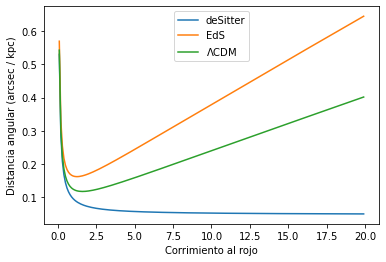

In [34]:
from astropy.cosmology import LambdaCDM


deSitter = LambdaCDM (H0=70, Om0=0, Ode0=1)
Einstein_de_Sitter = LambdaCDM (H0=70, Om0=1, Ode0=0)
lcdm = LambdaCDM (H0=70, Om0=0.3, Ode0=0.7)

labels = ["deSitter", "EdS", "$\Lambda$CDM"]

z = np.arange (0.1, 20, 0.1)

for imodel, ilabel  in zip([deSitter, Einstein_de_Sitter, lcdm], labels):
    plt.plot(z, imodel.arcsec_per_kpc_proper(z), label=ilabel)
plt.xlabel ("Corrimiento al rojo")
plt.ylabel ("Distancia angular ({})".format(imodel.arcsec_per_kpc_proper(z).unit))
plt.legend(loc="best")

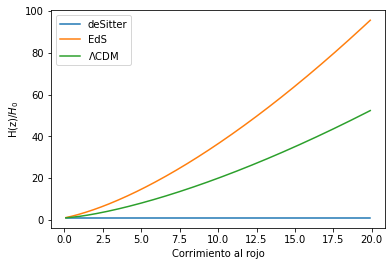

In [35]:
for imodel, ilabel  in zip([deSitter, Einstein_de_Sitter, lcdm], labels):
    plt.plot(z, imodel.H(z)/imodel.H0, label=ilabel)
plt.xlabel ("Corrimiento al rojo")
plt.ylabel ("H(z)/$H_0$")
plt.legend(loc="best")

In [36]:
Planck15.comoving_volume?

### Acceso a catálogos en línea

En la red existen varias bases de datos que podemos acceder para obtener información de nuestro objeto de interés o buscar objetos astronómicos que cumplan con ciertos criterios. Con python se puede automatizar estas búsquedas usando la libreria astroquery. Para instalarla podemos ejecutar el comando:

In [37]:
!pip install astroquery

Defaulting to user installation because normal site-packages is not writeable


In [38]:
from astroquery.simbad import Simbad as sim

res=sim.query_object("M74")
res.pprint(show_unit=True, max_width=500)

MAIN_ID       RA           DEC      RA_PREC DEC_PREC COO_ERR_MAJA COO_ERR_MINA COO_ERR_ANGLE COO_QUAL COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
           "h:m:s"       "d:m:s"                         mas          mas           deg                                                                  
------- ------------- ------------- ------- -------- ------------ ------------ ------------- -------- -------------- ------------------- ----------------
  M  74 01 36 41.7451 +15 47 01.107      14       14        0.393        0.296            90        A              O 2020yCat.1350....0G                1


In [39]:
from astroquery.ned import Ned
images = Ned.get_images("m74") 

BEGIN MAIN HEADER ---------------------------------                              [astropy.io.fits.card]
BEGIN EXTENSION HEADER ----------------------------                              [astropy.io.fits.card]


Numero de imagenes encontradas 143
Can not display image


Changed DATE-OBS from '23/11/54          ' to '1954-11-23''. [astropy.wcs.wcs]
Changed DATE-OBS from '21/10/84' to '1984-10-21''. [astropy.wcs.wcs]
Changed DATE-OBS from '30/01/98          ' to '1998-01-30''. [astropy.wcs.wcs]
Changed DATE-OBS from '30/01/98          ' to '1998-01-30''. [astropy.wcs.wcs]
Changed DATE-OBS from '08/10/91' to '1991-10-08''. [astropy.wcs.wcs]
Changed DATE-OBS from '08/10/91' to '1991-10-08''. [astropy.wcs.wcs]
Changed DATE-OBS from '08/10/91' to '1991-10-08''. [astropy.wcs.wcs]
Changed DATE-OBS from '08/10/91' to '1991-10-08''. [astropy.wcs.wcs]


Can not display image
Can not display image
Can not display image
Can not display image
Can not display image
Can not display image
Can not display image
Can not display image
Can not display image


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]

Can not display image
Can not display image
Can not display image
Can not display image
Can not display image


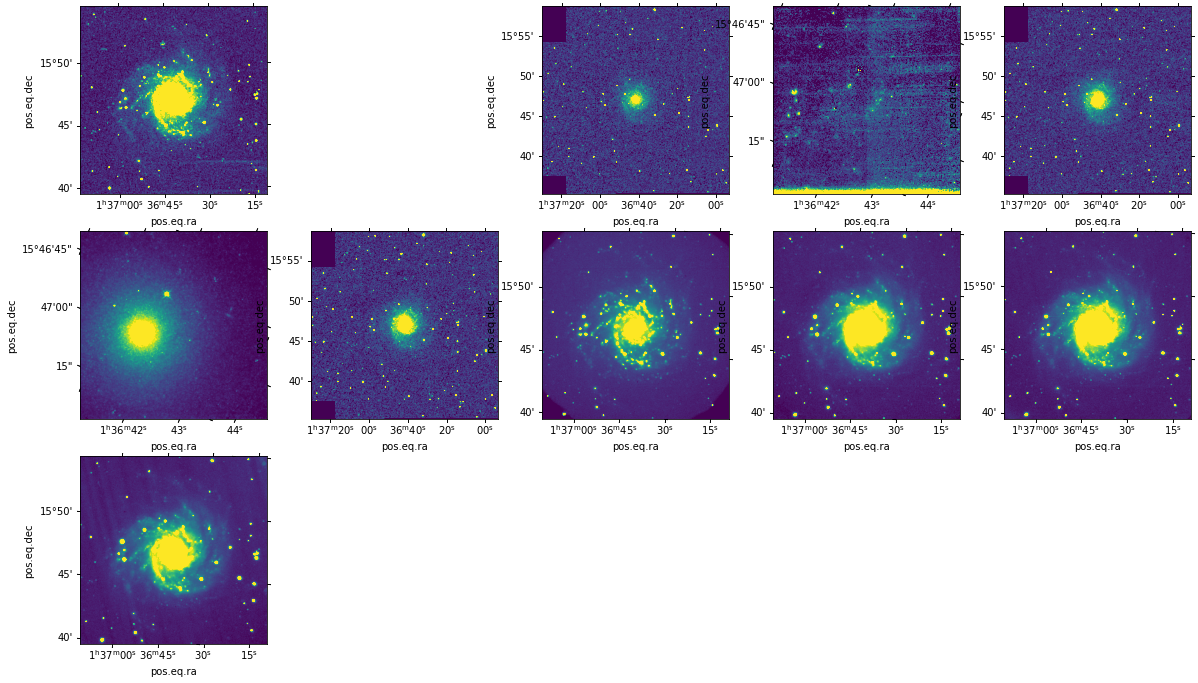

In [41]:
print ("Numero de imagenes encontradas {}".format(len (images)))
fig_por_row = 5
fig_por_col = 5
img_total = fig_por_row*fig_por_col
fig = plt.figure(figsize=(20,20))
for i in range (img_total):
    hdu = images[i]
    wcs = WCS(hdu[0].header)
    if wcs.naxis != 2:
        print ("Can not display image")
        continue
    fig.add_subplot(fig_por_row, fig_por_col, i+1, projection = wcs)
    cmedia, cmediana, cdevstd =  sigma_clipped_stats(hdu[0].data,sigma = 5.)
    plt.imshow(hdu[0].data, vmin = cmedia-cdevstd, vmax=cmedia+5*cdevstd)